# Notebook Setup

In [1]:
# Setting up with python 3.8.10
! pip install zfit==0.5.6 > /dev/null
! pip install mplhep > /dev/null
! pip install seaborn > /dev/null
! pip install numpy==1.19.5 > /dev/null
! pip install protobuf==3.20.0 > /dev/null

ERROR: -ensorflow 2.3.4 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.24.4 which is incompatible.
ERROR: tensorflow 2.3.4 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.24.4 which is incompatible.
ERROR: tensorboard 2.13.0 has requirement grpcio>=1.48.2, but you'll have grpcio 1.46.1 which is incompatible.
ERROR: -ensorflow 2.3.4 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: tensorflow 2.3.4 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: tensorboard 2.13.0 has requirement grpcio>=1.48.2, but you'll have grpcio 1.46.1 which is incompatible.
ERROR: seaborn 0.13.0 has requirement numpy!=1.24.0,>=1.20, but you'll have numpy 1.19.5 which is incompatible.


In [49]:
# Importing python libraries
import sys
import os
import time
import numpy as np
import pandas as pd
import zfit
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
# Adding to path custom libraries
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[1] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
# Importing custom libraries
import plot_tools
import customPDFs

In [59]:
# Minimizer import
import SLSQP_zfit

In [33]:
# Relative path to get the samplers

path = './samplers/'

# Zfit Configuration

In [7]:
# Setting the seed for zfit, to ensure equality of conditions
zfit.settings.set_seed(seed=42)

In [8]:
# Sampler size of 100,000 events = 1e5
sampler_size = 1e5

In [9]:
# Parameter space for the cosine
cos = zfit.Space('cosThetaKMu', [-1,1])

In [16]:
cos_np = np.linspace(-1, 1, 1000)

In [10]:
# Setting the parameters with initial values
AFB = zfit.Parameter('AFB', 0)
FH = zfit.Parameter('FH', 0)

In [11]:
# Creating the PDF with the selected parameters
decay_rate = customPDFs.decayWidth(AFB, FH, cos) # Crea una PDF del Base PDF de zfit

In [20]:
AFB_lst = [0, 0.25, -0.25, 0, -0.25, -0.7, 0.8]
FH_lst = [0, 0.5, 0.5, 1.5, 2.5, 1.5, 1.5]

In [21]:
# Creating a list of decay rates to store all the PDFs
decay_rate_lst = []

Text(1, 0, '$\\cos\\theta_{\\ell}$')

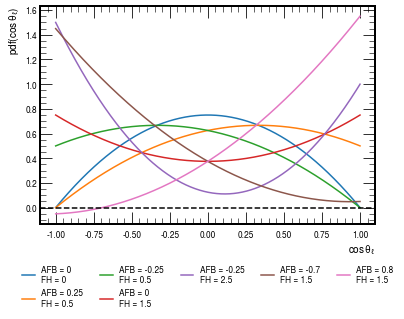

In [131]:
fig = plt.figure()
ax = plt.subplot(111)

for afb,fh in zip(AFB_lst, FH_lst):
    AFB.set_value(afb)
    FH.set_value(fh)
    decay_rate_lst.append(customPDFs.decayWidth(AFB, FH, cos))
    plt.plot(cos_np, decay_rate_lst[-1].pdf(cos_np), label=f'AFB = {afb}\nFH = {fh}')

AFB.set_value(0), FH.set_value(0)
#plt.plot(cos_np, decay_rate.pdf(cos_np), label=f'AFB = {0}\nFH = {0.02}', linewidth=5, color='black', ls='-')

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.axhline(0, color='black', ls='--')
plt.ylabel(r'pdf($\cos\theta_{\ell}$)')
plt.xlabel(r'$\cos\theta_{\ell}$')

In [56]:
# Creating the sampler list
sampler_lst = []

In [134]:
decay_rate_lst[6].params

OrderedDict([('AFB', <zfit.Parameter 'AFB' floating=True value=0>),
             ('FH', <zfit.Parameter 'FH' floating=True value=0>)])

(array([    0.,     0.,     0.,   128.,   438.,   888.,  1362.,  2008.,
         2679.,  3385.,  4097.,  4855.,  5967.,  6942.,  7999.,  9407.,
        10313., 11766., 13177., 14589.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

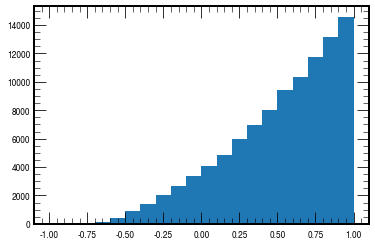

In [135]:
# Generating and saving the sampler
dr = decay_rate_lst[-1]

AFB.set_value(AFB_lst[-1]), FH.set_value(FH_lst[-1])

AFB_val = decay_rate_lst[-1].params['AFB'].value().numpy()
FH_val = decay_rate_lst[-1].params['FH'].value().numpy()

filename = f'{path}drs_AFB_{AFB_val}_FH_{FH_val}.npy'

# The PDf doesn´t save the values of the parameters themselves
# AFB.set_value(decay_rate_lst[-1].params['AFB'].value().numpy())
# FH.set_value(decay_rate_lst[-1].params['FH'].value().numpy())

sampler = decay_rate_lst[-1].create_sampler(sampler_size)

if os.path.exists(filename):
    #sampler_lst.append(sampler.from_numpy(cos, np.load(filename)))
    sampler = sampler.from_numpy(cos, np.load(filename))
else:
    sampler.resample()
    np.save(filename, sampler.numpy())
    #sampler_lst.append(sampler)
#print(sampler_lst[-1])
# 
plt.hist(sampler.numpy(), bins=20, range=[-1,1])
        

# Minimization

In [136]:
# Initial parameters

AFB.set_value(0.5)
FH.set_value(2.5)

In [108]:
ftol_lst = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [137]:
nll = zfit.loss.UnbinnedNLL(decay_rate_lst[-1], sampler)

## Minuit Minimization

In [138]:
MIN = zfit.minimize.Minuit()

# Minimization time =====================================
start = time.time()
# Minimization with zfit minuit
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()
print("Minimization time with Minuit", end - start)

# Hessian error calculator time =========================
start = time.time()

minimum.hesse()

end = time.time()
print("Hessian error time with Minuit", end - start)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.936e+04                  │        Nfcn = 201 (201 total)        │
│ EDM = 8.8e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
FitResult of
<UnbinnedNLL model=[<zfit.decayWidth  params=[AFB, FH] dtype=float64>0] data=[<zfit.core.data.Sampler object at 0x7f091b976f10>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════

# SLSQP_zfit minimization

In [139]:
constraints = SLSQP_zfit.create_constraint(decay_rate_lst[-1]) #una constraint se crea con una pdf
# Constraints are a dictionary with 'type' and 'fun' arguments
# Creates a new minimizer implementation from the base minimizer
SLSQP = SLSQP_zfit.SLSQP(constraints=constraints, ftol = 1e-6)

0 1
ftol = 1e-06


In [140]:
# Esto devolvía un error al correr en versiones anteriores
# El error indica lo siguiente:
# NotImplementedError: Cannot convert a symbolic Tensor (gradients/gradients/AddN_16/inputs_1_grad/sub:0) to a numpy array. 
# This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# Solución encontrada en Stack Overflow:
# https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy

# numpy==1.19.5

# Minimization time for SLSQP_zfit =============================
start = time.time()

minimum = SLSQP.minimize(nll)
print(minimum)

end = time.time()

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

start = time.time()

minimum.hesse()

end = time.time()
print("Hessian error time with SLSQP zfit", end - start)

FitResult of
<UnbinnedNLL model=[<zfit.decayWidth  params=[AFB, FH] dtype=float64>0] data=[<zfit.core.data.Sampler object at 0x7f091b976f10>] constraints=[]> 
with
<function minimize at 0x7f09e4274dc0>

╒═════════╤═════════════╤══════════════════╤═══════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm   │ min value   │
╞═════════╪═════════════╪══════════════════╪═══════╪═════════════╡
│ True    │ True        │ False            │ -1    │ 2.085e+04   │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
AFB      0.8126       False
FH        1.625       False
Minimization time with SLSQP zfit 0.26035475730895996
Hessian error time with SLSQP zfit 1.4808306694030762
